In [ ]:
import os
import shutil
import re
from fnmatch import fnmatch
import logging
from pathlib import Path
import csv
import pandas as pd
import numpy as np


: 

In [92]:
sample_path = ["../dataset/A-2556-6L-UN-P1_3-01-T.bmp", "../dataset/A04763-6L-UM-P0_1-01-T.bmp"]
csv_path = "../dataset/csv/label.csv"
origins = "../dataset/origin"


In [93]:

label = pd.read_csv(csv_path)
label

,img,label
0,A00220-6R-UN-P0_2-06-N.bmp,0
1,A04624-6L-UM-P0_9-03-T.bmp,0
2,A02036-6R-UN-P4_7-07-N.bmp,1
3,A00251-6L-UM-P3_6-04-N.bmp,1
4,A01458-4L-UM-P1_6-6-N.bmp,1
...,...,...
16272,A01068-6L-UM-P3_3-01-N.bmp,1
16273,A04665-6L-UM-P3_6-02-T.bmp,1
16274,A01526-6R-UM-P2_6-05-N.bmp,1
16275,A02033-6R-UN-P0_6-09-N.bmp,0


2080


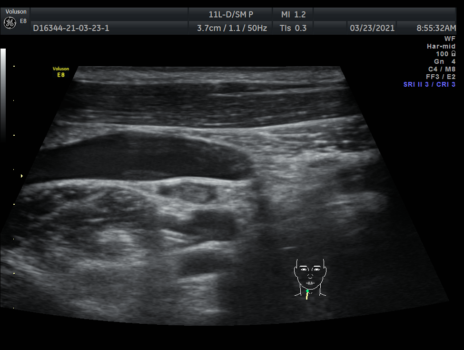

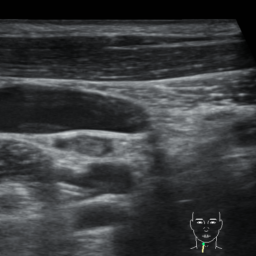

In [114]:
from importlib.resources import path
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
path_list = os.listdir("../dataset/origin/")
import random
x = int(random.random() *14000)
print(x)
img = Image.open(os.path.join("../dataset/origin", path_list[x]))
transform1 = transforms.Resize(350              )
img = transform1(img)
img.show()
transform= transforms.CenterCrop((256, 256))
transform2 = transforms.RandomHorizontalFlip(0.5)
img = transform(img)
img.show()

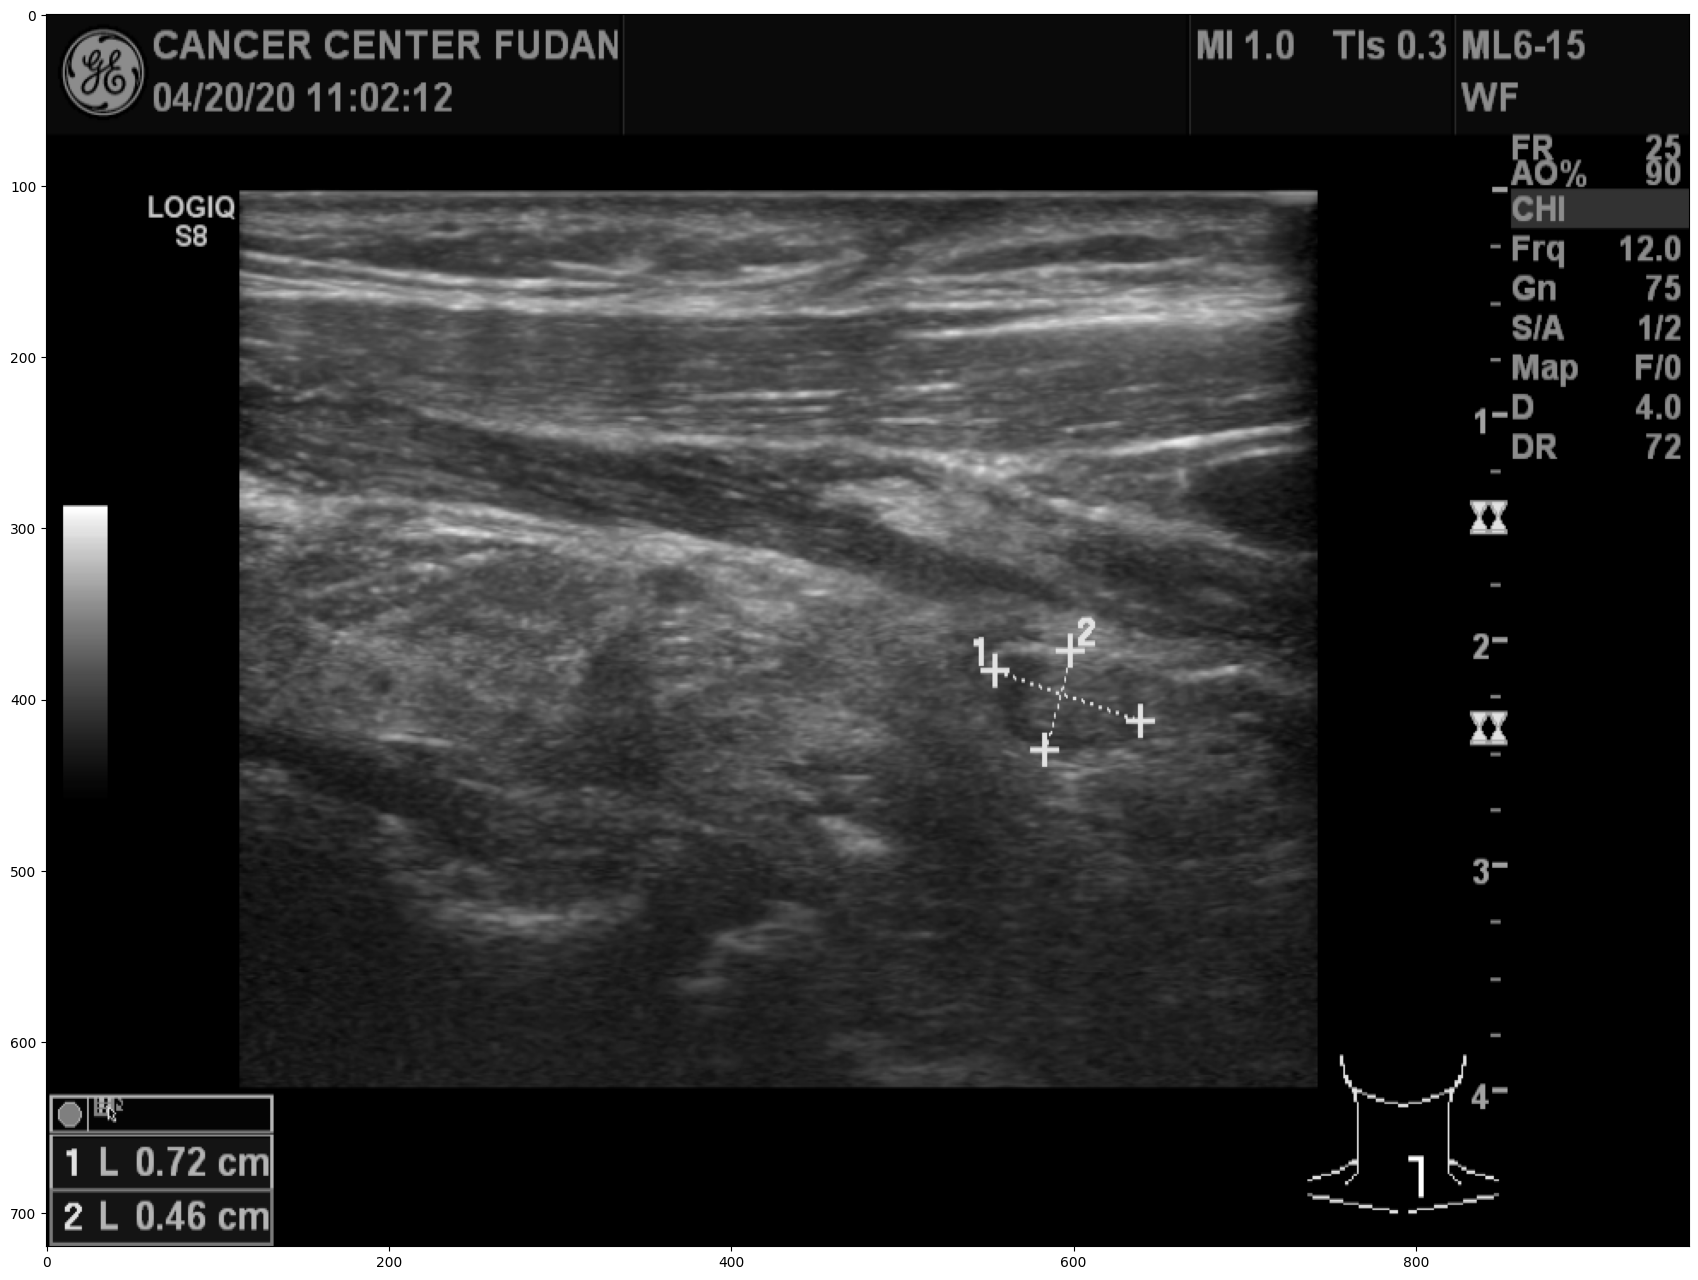

In [35]:
import cv2
import matplotlib.pyplot  as plt
# IMG_SIZE=512
fig = plt.figure(figsize=(25, 16))
image = cv2.imread(sample_path[1])
image = crop_image(image)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
# image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128)
plt.imshow(image,cmap='gray')

In [18]:
%pip install opencv-python
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 9.8 MB/s eta 0:00:00:00:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
a = label.iloc[:,1].value_counts()

In [34]:
def crop_image1(img, tol=7):
    mask = img>tol
    return img[np.ix_(mask.any(1), mask.any(0))]
    
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image>1)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

def autocrop(image, threshold=0):
    """Crops any edges below or equal to threshold

    Crops blank image to 1x1.

    Returns cropped image.

    """
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

def crop_image4(image):
    _,thresh = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = image[y:y+h,x:x+w]
    return crop

def crop_image3(image):
    mask = image > 0

    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]
    return cropped

def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img
    
def crop_image2(image,threshold=5):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image


FileExistsError: [Errno 17] File exists: '../dataset/preprocessed'